# Plan: Hybrid Visual Product Search

## Objective
Build a robust product search engine that leverages both visual features and semantic understanding to retrieve relevant products from the **Amazon Berkeley Objects (ABO)** dataset.

## Architecture: Two-Model Approach

We will implement a **Query Expansion** strategy using a multimodal ensemble. This addresses the limitations of pure visual search (which misses semantic meaning) and pure text search (which misses visual style).

### 1. Model 1: Image Captioner (The "Translator")
*   **Role:** Converts the visual content of the query image into a rich textual description.
*   **Model:** `Salesforce/blip-image-captioning-base` (or similar VLM like LLaVA/InstructBLIP).
*   **Why?** CLIP sometimes misses specific details (brand names, specific counts, nuanced attributes). A captioner acts as a "semantic bridge."
*   **Output:** Text string (e.g., *"A stainless steel travel coffee mug with a black handle and a Starbucks logo"*).

### 2. Model 2: Dual Encoder (The "Embedder")
*   **Role:** Maps inputs into a shared vector space for similarity search.
*   **Model:** `openai/clip-vit-base-patch32`.
*   **Process:**
    *   **Branch A (Visual):** Encode the original **Image** into a vector $V_{img}$.
    *   **Branch B (Text):** Encode the **Generated Description** into a vector $V_{txt}$.
    *   **Fusion:** Combine these vectors (e.g., Mean Pooling: $V_{final} = \frac{V_{img} + V_{txt}}{2}$) to get a robust query representation.

### 3. Retrieval System
*   **Index:** A vector database (FAISS or simple Tensor search) containing CLIP embeddings of the ABO catalog images.
*   **Search:** Compute Cosine Similarity between $V_{final}$ and the Catalog Index.

## Implementation Steps
1.  **Data Loading:** parsing the ABO metadata and loading images.
2.  **Indexing:** Generate CLIP embeddings for a subset of the ABO catalog.
3.  **Pipeline Construction:**
    *   Define `generate_caption(image)` function.
    *   Define `get_embedding(image, text)` function.
4.  **Search Logic:** Implement the retrieval and ranking.
5.  **Evaluation:** Qualitative testing with sample images.

In [1]:
import os
import pandas as pd
from pathlib import Path
from PIL import Image
import gzip
import json

# Set the path to the dataset relative to the notebook
# The notebook is in 'two-tower/', data is in 'data/abo/' at the project root.
DATA_ROOT = Path("../data/abo")

# Verify the path exists
if not DATA_ROOT.exists():
    print(f"Warning: {DATA_ROOT} does not exist. Check your current working directory.")
    print(f"Current Directory: {os.getcwd()}")
else:
    print(f"Data Root found at: {DATA_ROOT.resolve()}")

Data Root found at: /Users/hrishikesh/Developer/visual-product-search/data/abo


In [2]:
# 1. Load Listings Metadata (Product Info)
# The listings are split into multiple JSON.GZ files. We'll load the first one as a sample.
listing_path = DATA_ROOT / "listings/metadata/listings_0.json.gz"

print(f"Loading listings from: {listing_path}")
try:
    # Read line-delimited JSON
    df_listings = pd.read_json(listing_path, lines=True)
    print(f"Loaded {len(df_listings)} products.")
    display(df_listings.head(2))
except Exception as e:
    print(f"Error loading listings: {e}")

# 2. Load Image Metadata (Paths)
# This CSV maps image_id to the relative path of the image file.
images_meta_path = DATA_ROOT / "images/metadata/images.csv.gz"

print(f"\nLoading image metadata from: {images_meta_path}")
try:
    df_images = pd.read_csv(images_meta_path)
    print(f"Loaded {len(df_images)} image records.")
    display(df_images.head(2))
except Exception as e:
    print(f"Error loading image metadata: {e}")

Loading listings from: ../data/abo/listings/metadata/listings_0.json.gz
Loaded 9232 products.


brand  \
0      [{'language_tag': 'nl_NL', 'value': 'find.'}]   
1  [{'language_tag': 'es_MX', 'value': 'AmazonBas...   

                                        bullet_point  \
0  [{'language_tag': 'nl_NL', 'value': 'Schoen in...   
1  [{'language_tag': 'es_MX', 'value': 'White Pow...   

                                               color     item_id  \
0  [{'language_tag': 'nl_NL', 'value': 'Veelkleur...  B06X9STHNG   
1  [{'language_tag': 'es_MX', 'value': 'White Pow...  B07P8ML82R   

                                           item_name  \
0  [{'language_tag': 'nl_NL', 'value': 'Amazon-me...   
1  [{'language_tag': 'es_MX', 'value': '22" Botto...   

                                      model_name  \
0  [{'language_tag': 'nl_NL', 'value': '37753'}]   
1                                            NaN   

                   model_number         model_year             product_type  \
0       [{'value': '12-05-04'}]  [{'value': 2017}]     [{'value': 'SHOES'}]   
1  [{'value': 'AB5013-R22-10'}]                NaN  [{'value': 'HARDWARE'}]   

                                               style  ...  \
0  [{'language_tag': 'nl_NL', 'value': 'Gesloten-...  ...   
1   [{'language_tag': 'es_MX', 'value': '10 pares'}]  ...   

                                         item_weight material fabric_type  \
0                                                NaN      NaN         NaN   
1  [{'normalized_value': {'unit': 'pounds', 'valu...      NaN         NaN   

  color_code product_description spin_id 3dmodel_id pattern finish_type  \
0        NaN                 NaN     NaN        NaN     NaN         NaN   
1        NaN                 NaN     NaN        NaN     NaN         NaN   

  item_shape  
0        NaN  
1        NaN  

[2 rows x 28 columns]


Loading image metadata from: ../data/abo/images/metadata/images.csv.gz
Loaded 398212 image records.


image_id  height  width             path
0  010-mllS7JL     106    106  14/14fe8812.jpg
1  01dkn0Gyx0L     122    122  da/daab0cad.jpg

In [3]:
# 3. Filter for Downloaded Images (Since we only downloaded a subset)
# Function to check if image file exists
def get_full_path(relative_path):
    return DATA_ROOT / "images/original" / relative_path

# Add full path column
df_images['full_path'] = df_images['path'].apply(get_full_path)

# Filter: keep only rows where the file exists on disk
# This is crucial because we did a partial download (approx 5GB)
print("Filtering for existing image files...")
df_available = df_images[df_images['full_path'].apply(lambda x: x.exists())].copy()

print(f"Total images in metadata: {len(df_images)}")
print(f"Images found on disk: {len(df_available)}")
display(df_available.head())

# 4. Merge with Product Info
# In ABO, listings usually link to images via 'main_image_id' or similar.
# Let's inspect columns to find the link.
print("Listing columns:", df_listings.columns.tolist())
if 'main_image_id' in df_listings.columns:
    merge_key = 'main_image_id'
elif 'image_id' in df_listings.columns:
    merge_key = 'image_id'
else:
    # Fallback: Check if 'item_id' matches
    merge_key = None
    print("Warning: Could not automatically detect image ID column in listings.")

if merge_key:
    # Merge listings with available images
    df_merged = pd.merge(df_listings, df_available, left_on=merge_key, right_on='image_id', how='inner')
    print(f"Products with available images: {len(df_merged)}")
    display(df_merged[['item_id', 'item_name', 'path', 'full_path']].head())
else:
    df_merged = df_available # Fallback for now

Filtering for existing image files...
Total images in metadata: 398212
Images found on disk: 49615


image_id  height  width             path  \
0   010-mllS7JL     106    106  14/14fe8812.jpg   
18  21+KGgoGHkL     500    375  12/12bdb2fc.jpg   
24  21+X-uttvbL     300    300  1c/1c58212f.jpg   
30  21+jwTc3JYL     500    375  16/165b2093.jpg   
37  21-6JdQxZNL     500    375  10/1041934c.jpg   

                                      full_path  
0   ../data/abo/images/original/14/14fe8812.jpg  
18  ../data/abo/images/original/12/12bdb2fc.jpg  
24  ../data/abo/images/original/1c/1c58212f.jpg  
30  ../data/abo/images/original/16/165b2093.jpg  
37  ../data/abo/images/original/10/1041934c.jpg

Listing columns: ['brand', 'bullet_point', 'color', 'item_id', 'item_name', 'model_name', 'model_number', 'model_year', 'product_type', 'style', 'main_image_id', 'other_image_id', 'item_keywords', 'country', 'marketplace', 'domain_name', 'node', 'item_dimensions', 'item_weight', 'material', 'fabric_type', 'color_code', 'product_description', 'spin_id', '3dmodel_id', 'pattern', 'finish_type', 'item_shape']
Products with available images: 1175


item_id                                          item_name  \
0  B0896LJNLH  [{'language_tag': 'en_US', 'value': 'AmazonBas...   
1  B07J4HXTQH  [{'language_tag': 'de_DE', 'value': 'AmazonBas...   
2  B07T9TND12  [{'language_tag': 'en_IN', 'value': 'Amazon Br...   
3  B01N5XROXR  [{'language_tag': 'en_AE', 'value': 'Amazon Br...   
4  B07TJVSBV1  [{'language_tag': 'en_IN', 'value': 'Amazon Br...   

              path                                    full_path  
0  07/075e5d67.jpg  ../data/abo/images/original/07/075e5d67.jpg  
1  1e/1e39ce5a.jpg  ../data/abo/images/original/1e/1e39ce5a.jpg  
2  04/040353c9.jpg  ../data/abo/images/original/04/040353c9.jpg  
3  14/14d129a0.jpg  ../data/abo/images/original/14/14d129a0.jpg  
4  00/0055d71a.jpg  ../data/abo/images/original/00/0055d71a.jpg

Product: [{'language_tag': 'en_IN', 'value': 'Amazon Brand - Solimo Designer Leather Texture 3D Printed Hard Back Case Mobile Cover for Vivo Y55L'}]


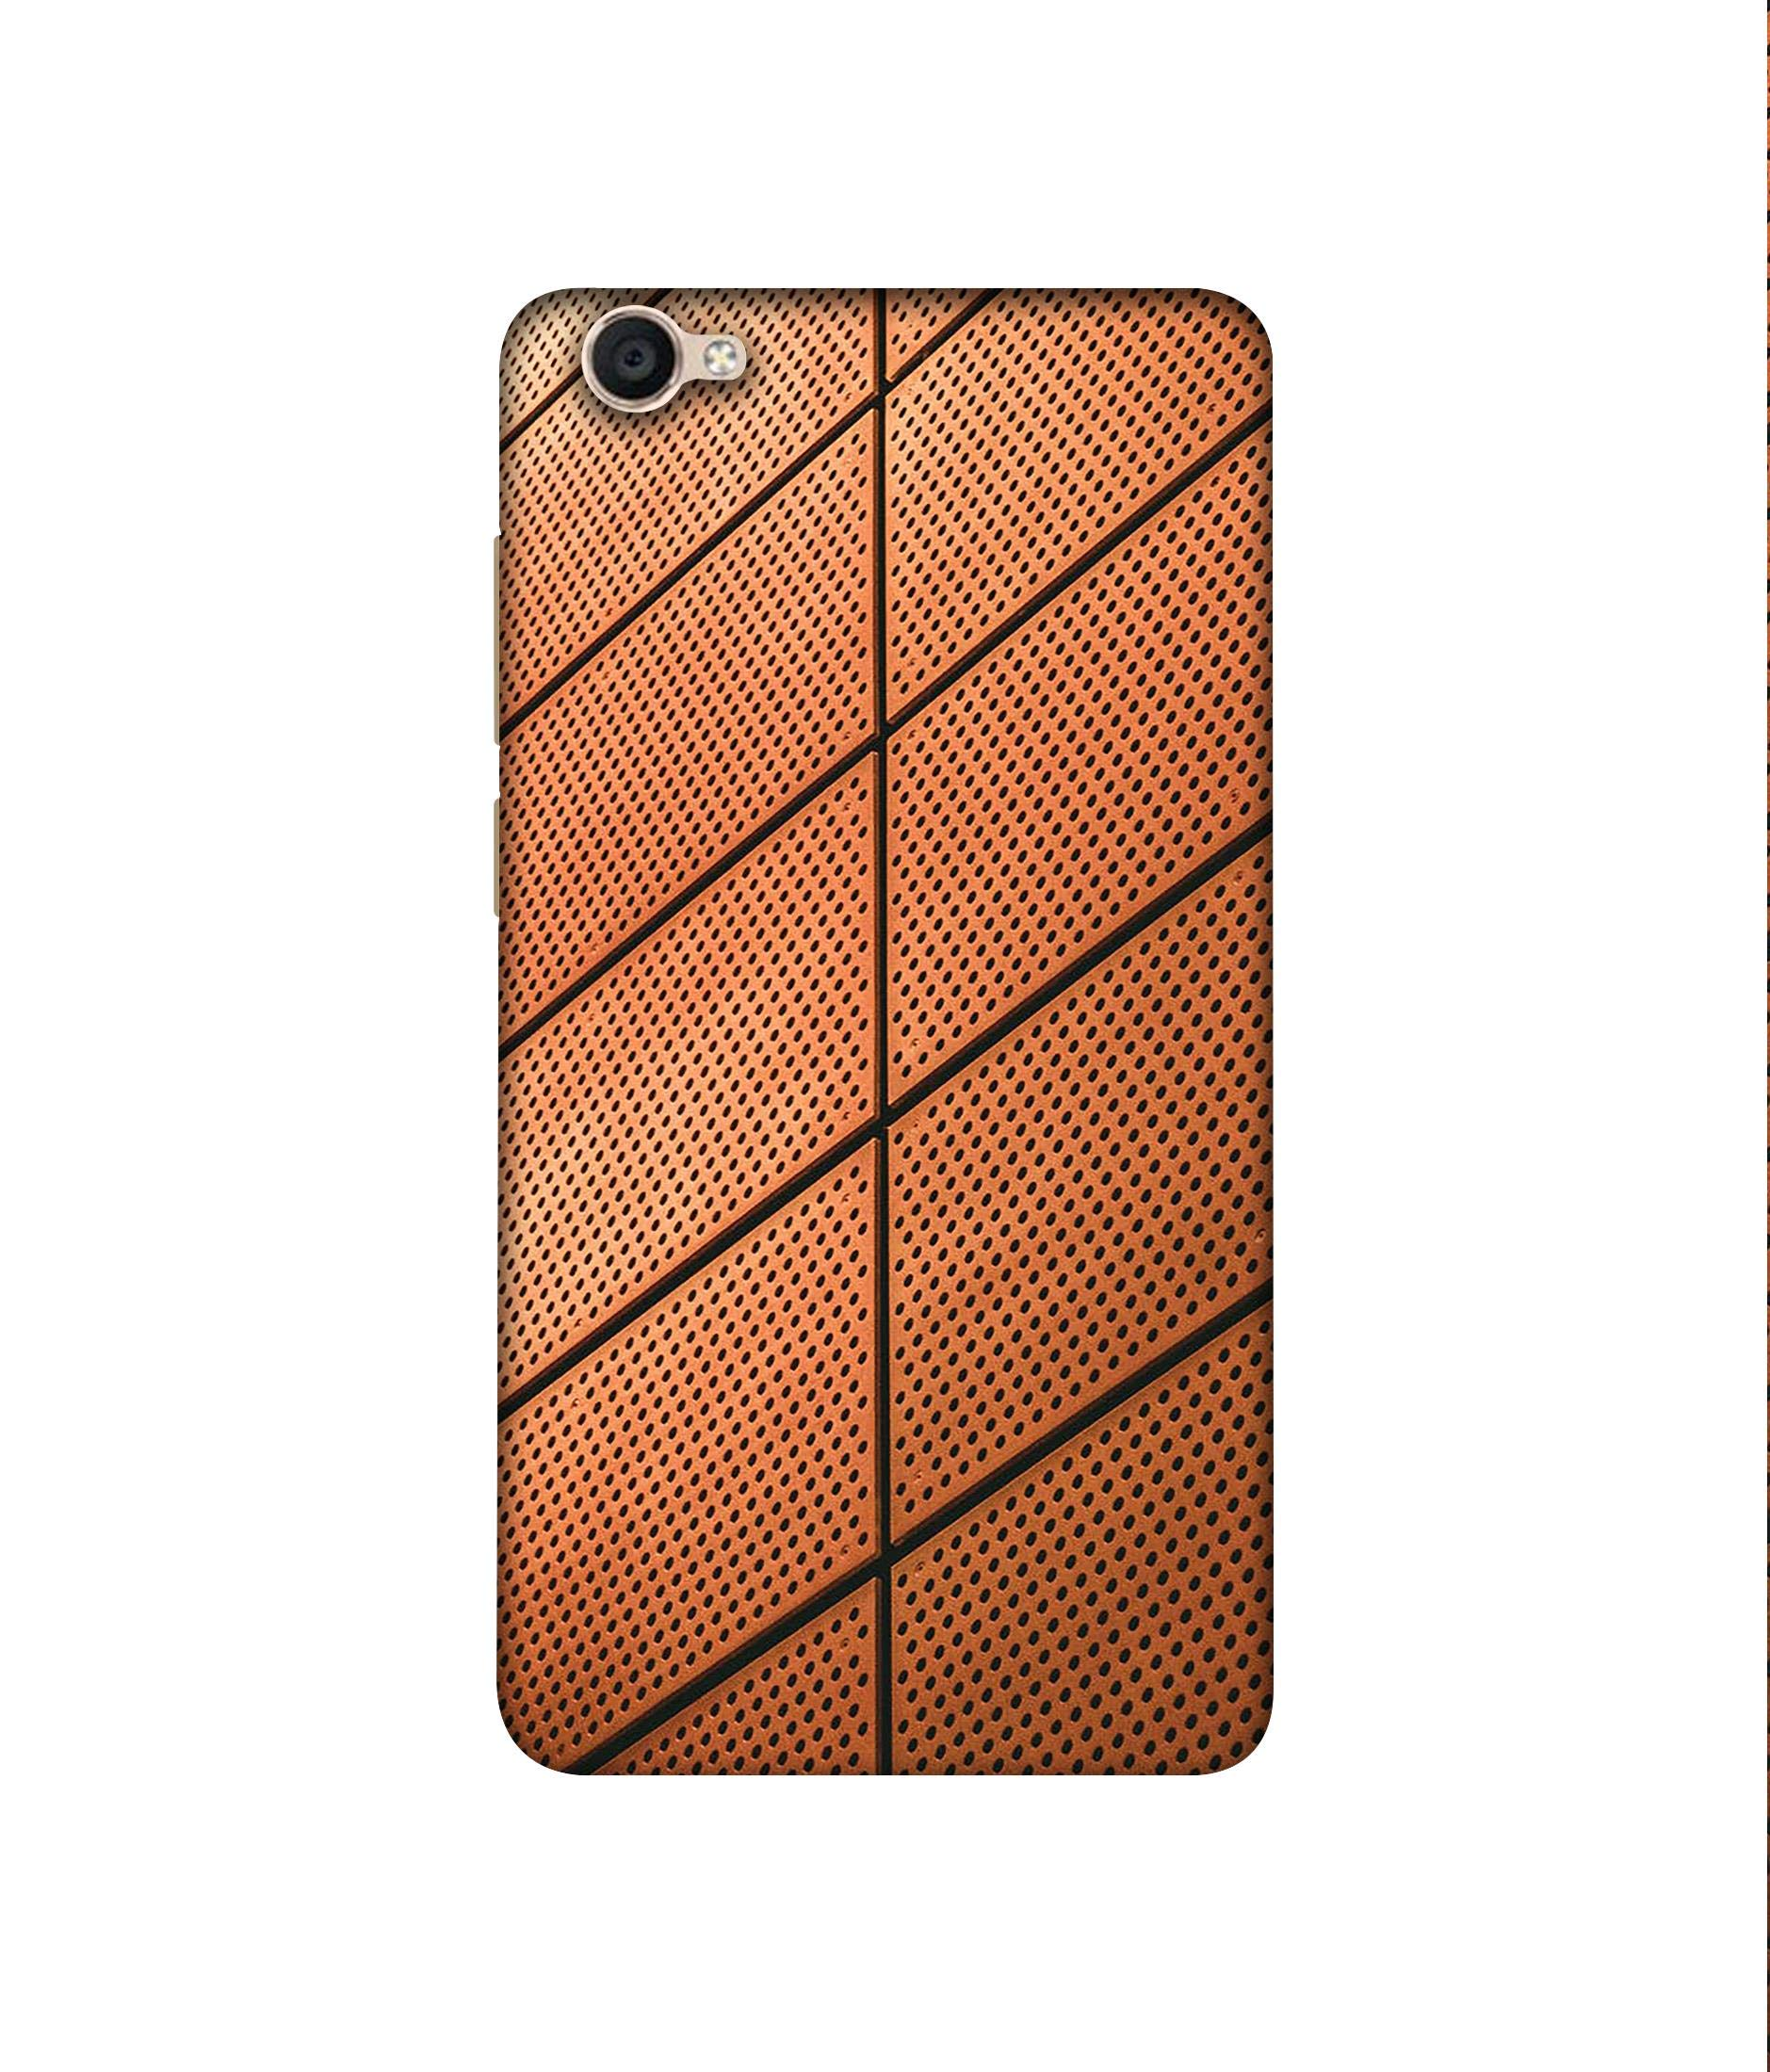

In [4]:
# 5. Visualize a Sample
# Take a random sample from our verified dataset
if not df_merged.empty:
    sample = df_merged.sample(1).iloc[0]
    
    img_path = sample['full_path']
    if 'item_name' in sample:
        title = sample['item_name']
    else:
        title = "Unknown Product"
        
    print(f"Product: {title}")
    # print(f"Path: {img_path}") # Optional debugging
    
    try:
        display(Image.open(img_path))
    except Exception as e:
        print(f"Error opening image: {e}")
else:
    print("No images found to display. Did you run the download script?")

# Step 2: Indexing (Generating Embeddings)
We will now generate vector embeddings for our product images using the CLIP model (`openai/clip-vit-base-patch32`). 
These embeddings will serve as our search index.

### Prerequisites
Ensure you have `torch` and `transformers` installed:
```bash
pip install torch transformers tqdm
```

In [5]:
import torch
from transformers import CLIPModel, CLIPProcessor
from tqdm.auto import tqdm
import numpy as np

# 1. Load CLIP Model
model_id = "openai/clip-vit-base-patch32"
print(f"Loading CLIP model: {model_id}...")

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

try:
    model = CLIPModel.from_pretrained(model_id).to(device)
    processor = CLIPProcessor.from_pretrained(model_id)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")

/Users/hrishikesh/Developer/visual-product-search/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading CLIP model: openai/clip-vit-base-patch32...
Using device: mps


Loading weights: 100%|██████████| 398/398 [00:00<00:00, 2137.18it/s, Materializing param=visual_projection.weight]                                
CLIPModel LOAD REPORT from: openai/clip-vit-base-patch32
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
text_model.embeddings.position_ids   | UNEXPECTED |  | 
vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
The image processor of type `CLIPImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


Model loaded successfully.


In [7]:
# 2. Generate Embeddings (Batched)
# We will process images in batches to avoid memory issues.
BATCH_SIZE = 32

def generate_image_embeddings(image_paths, batch_size=32):
    all_embeddings = []
    
    # Process in chunks
    for i in tqdm(range(0, len(image_paths), batch_size), desc="Encoding Images"):
        batch_paths = image_paths[i:i + batch_size]
        valid_images = []
        valid_indices = []
        
        # Load images (handle potential errors)
        for idx, p in enumerate(batch_paths):
            try:
                img = Image.open(p).convert("RGB")
                valid_images.append(img)
                valid_indices.append(idx)
            except Exception as e:
                print(f"Skipping error image {p}: {e}")
                
        if not valid_images:
            continue
            
        # Preprocess and Forward Pass
        inputs = processor(images=valid_images, return_tensors="pt", padding=True).to(device)
        
        with torch.no_grad():
            outputs = model.get_image_features(**inputs)
            
            # Handle different output types (Tensor vs BaseModelOutput)
            if isinstance(outputs, torch.Tensor):
                image_features = outputs
            else:
                if hasattr(outputs, 'image_embeds'):
                    image_features = outputs.image_embeds
                elif hasattr(outputs, 'pooler_output'):
                    image_features = outputs.pooler_output
                else:
                    image_features = outputs[0]
            
            # Normalize embeddings for cosine similarity
            embeddings = image_features / image_features.norm(p=2, dim=-1, keepdim=True)
            embeddings = embeddings.cpu().numpy()
            
        all_embeddings.append(embeddings)

    if all_embeddings:
        return np.vstack(all_embeddings)
    else:
        return np.array([])

# Run on our dataset
# We'll use a subset if the dataset is huge just for testing, or full if comfortable.
# Let's take 'full_path' column from our merged dataframe.

print(f"Generating embeddings for {len(df_merged)} images...")

# Extract paths
image_paths = df_merged['full_path'].tolist()

# Let's limit to 1000 for quick testing if user wants (uncomment to limit)
# image_paths = image_paths[:1000] 

if image_paths:
    image_embeddings = generate_image_embeddings(image_paths, BATCH_SIZE)
    print(f"Embeddings Shape: {image_embeddings.shape}")
    
    # Save embeddings for later use?
    # np.save("abo_image_embeddings.npy", image_embeddings)
else:
    print("No images to process.")

Generating embeddings for 1175 images...


Encoding Images: 100%|██████████| 37/37 [00:18<00:00,  1.95it/s]

Embeddings Shape: (1175, 512)


# Step 3: Pipeline Construction (Hybrid Search)
Now we build the two-model pipeline:
1.  **Image Captioner (BLIP):** To generate a text description of the query image.
2.  **Embedder (CLIP):** To generate embeddings for both the image and the generated text.

We will combine these embeddings to form a "Hybrid Query" that captures both visual style and semantic content.

In [8]:
from transformers import BlipProcessor, BlipForConditionalGeneration

# 1. Load Captioning Model (BLIP)
blip_model_id = "Salesforce/blip-image-captioning-base"
print(f"Loading BLIP model: {blip_model_id}...")

try:
    blip_processor = BlipProcessor.from_pretrained(blip_model_id)
    blip_model = BlipForConditionalGeneration.from_pretrained(blip_model_id).to(device)
    print("BLIP model loaded successfully.")
except Exception as e:
    print(f"Error loading BLIP model: {e}")

Loading BLIP model: Salesforce/blip-image-captioning-base...


The image processor of type `BlipImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 
Loading weights: 100%|██████████| 473/473 [00:00<00:00, 703.36it/s, Materializing param=vision_model.post_layernorm.weight]                                       
The tied weights mapping and config for this model specifies to tie text_decoder.cls.predictions.bias to text_decoder.cls.predictions.decoder.bias, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie text_decoder.bert.embeddings.word_embeddings.weight to text_decoder.cls.predictions.decoder.weight, but both are present in the checkpoints, so we will NOT t

BLIP model loaded successfully.


In [9]:
# 2. Define Helper Functions

def generate_caption(image):
    """
    Generates a text description for a given PIL Image.
    """
    inputs = blip_processor(image, return_tensors="pt").to(device)
    
    # Generate caption
    with torch.no_grad():
        out = blip_model.generate(**inputs, max_new_tokens=50)
    
    caption = blip_processor.decode(out[0], skip_special_tokens=True)
    return caption

def get_hybrid_embedding(image, caption):
    """
    Generates a hybrid embedding by:
    1. Getting CLIP image embedding
    2. Getting CLIP text embedding (of the caption)
    3. Averaging them (you can also use weighted average)
    """
    with torch.no_grad():
        # A. Image Embedding
        img_inputs = processor(images=image, return_tensors="pt", padding=True).to(device)
        img_out = model.get_image_features(**img_inputs)
        
        # Handle different output types
        if hasattr(img_out, 'image_embeds'):  img_emb = img_out.image_embeds
        elif hasattr(img_out, 'pooler_output'): img_emb = img_out.pooler_output
        elif isinstance(img_out, torch.Tensor): img_emb = img_out
        else: img_emb = img_out[0]
            
        img_emb = img_emb / img_emb.norm(p=2, dim=-1, keepdim=True)
        
        # B. Text Embedding (from Caption)
        txt_inputs = processor(text=[caption], return_tensors="pt", padding=True).to(device)
        txt_out = model.get_text_features(**txt_inputs)
        
        # Handle different output types
        if hasattr(txt_out, 'text_embeds'): txt_emb = txt_out.text_embeds
        elif hasattr(txt_out, 'pooler_output'): txt_emb = txt_out.pooler_output
        elif isinstance(txt_out, torch.Tensor): txt_emb = txt_out
        else: txt_emb = txt_out[0]
            
        txt_emb = txt_emb / txt_emb.norm(p=2, dim=-1, keepdim=True)
        
        # C. Fusion (Average)
        # You can tune weights: 0.6 * img + 0.4 * txt, etc.
        hybrid_emb = (img_emb + txt_emb) / 2.0
        
        # Re-normalize just in case
        hybrid_emb = hybrid_emb / hybrid_emb.norm(p=2, dim=-1, keepdim=True)
        
        return hybrid_emb.cpu().numpy()

print("Pipeline functions defined.")

Pipeline functions defined.


# Step 4: Search Logic (Retrieval & Ranking)
The retrieval function will:
1.  **Process** the new query image (generate description + embeddings).
2.  **Calculate Similarity** (Cosine Distance) between the query vector and the entire index.
3.  **Rank** results and display the Top K matches.

In [10]:
import matplotlib.pyplot as plt

def search_products(query_image_path, top_k=5):
    """
    Retrieves the most similar products for a given local image path.
    """
    if not os.path.exists(query_image_path):
        print(f"File not found: {query_image_path}")
        return

    # --- 1. Process Query Image ---
    print(f"Processing query: {query_image_path}")
    raw_image = Image.open(query_image_path).convert("RGB")
    
    # Generate Caption
    # We use the 'generate_caption' function from Step 3
    generated_caption = generate_caption(raw_image)
    print(f"Generated Description: '{generated_caption}'")
    
    # Generate Hybrid Embedding
    # We use the 'get_hybrid_embedding' function from Step 3
    query_embedding = get_hybrid_embedding(raw_image, generated_caption)
    
    # --- 2. Calculate Similarity ---
    # Since vectors are normalized, Dot Product == Cosine Similarity
    # Shapes: (1, 512) @ (N, 512).T -> (1, N)
    sim_scores = query_embedding @ image_embeddings.T
    sim_scores = sim_scores[0] # Flatten to 1D array
    
    # --- 3. Rank Results ---
    # Get top K indices (sorted descending)
    top_indices = np.argsort(sim_scores)[::-1][:top_k]
    
    # --- 4. Display Results ---
    print("\n" + "="*30)
    print("       TOP RESULTS")
    print("="*30)
    
    # Plotting
    fig, axes = plt.subplots(1, top_k + 1, figsize=(15, 5))
    
    # Show Query
    axes[0].imshow(raw_image)
    axes[0].set_title("Query Image\n(User Input)")
    axes[0].axis('off')
    
    # Show Matches
    for i, idx in enumerate(top_indices):
        score = sim_scores[idx]
        
        # Get metadata from our dataframe
        record = df_merged.iloc[idx]
        img_path = record['full_path']
        
        # Safely get title
        try:
             # some datasets have 'item_name', others might differ. Adjust as needed.
            title = record.get('item_name', [])
            if isinstance(title, list): # Some listings have titles as lists
                title = title[0]['value'] if title else "Unknown"
            elif isinstance(title, str):
                pass # it's already a string
            else:
                 title = "Unknown Product"
        except:
            title = "Unknown"

        # Truncate title for display
        short_title = (title[:30] + '..') if len(title) > 30 else title
        
        try:
            matched_img = Image.open(img_path).convert("RGB")
            axes[i+1].imshow(matched_img)
            axes[i+1].set_title(f"Rank #{i+1}\nSc: {score:.3f}\n{short_title}")
            axes[i+1].axis('off')
        except Exception as e:
            print(f"Error loading result image {img_path}: {e}")
            
    plt.tight_layout()
    plt.show()

print("Search engine ready.")

Search engine ready.


Testing with query image: ../data/abo/images/original/12/128c9218.jpg
Processing query: ../data/abo/images/original/12/128c9218.jpg
Generated Description: 'a white bed with a white sheet on it'

       TOP RESULTS


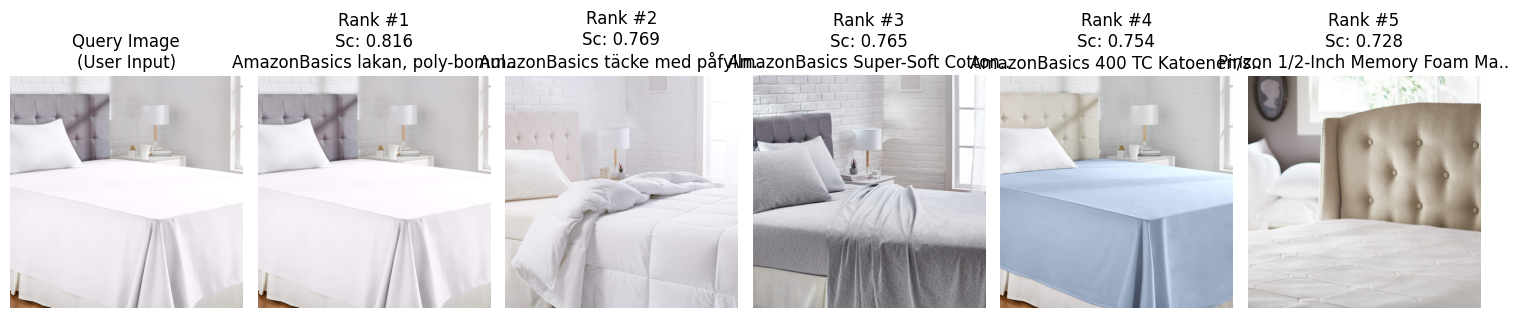

In [11]:
# 5. Test the Pipeline
# Let's take a random image from our dataset to simulate a "query"
sample_query_path = df_merged.sample(1).iloc[0]['full_path']
print(f"Testing with query image: {sample_query_path}")

search_products(str(sample_query_path), top_k=5)

# Step 5: Evaluation
Since we don't have a labeled "Ground Truth" test set for retrieval (i.e., we don't know exactly which product *should* be returned for a random photo), we will perform **Qualitative Evaluation**.

We will:
1.  Select a few distinct products (e.g., shoe, furniture, electronics).
2.  Run the Hybrid Search.
3.  Visually inspect if the Top-5 results are relevant.

Running Qualitative Evaluation on 3 samples...

--- Eval Query: [{'language_tag': 'es_ES', 'value': 'Marca Amazon - RED WAGON Botines de Serraje para Niño, unisex'}] ---
Processing query: ../data/abo/images/original/19/194fed66.jpg
Generated Description: 'a pair of blue sued boots with red soles'

       TOP RESULTS


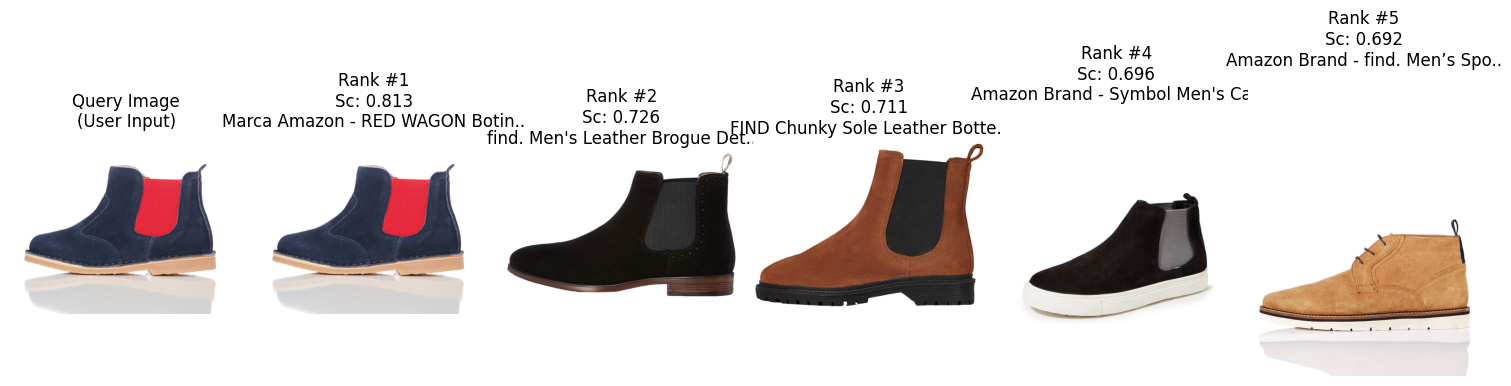

--- Eval Query: [{'language_tag': 'en_US', 'value': '365 EVERYDAY VALUE Organic Seeded Sandwhich Bread, 20 OZ'}] ---
Processing query: ../data/abo/images/original/11/1169532e.jpg
Generated Description: 'a bag of bread with a label on it'

       TOP RESULTS


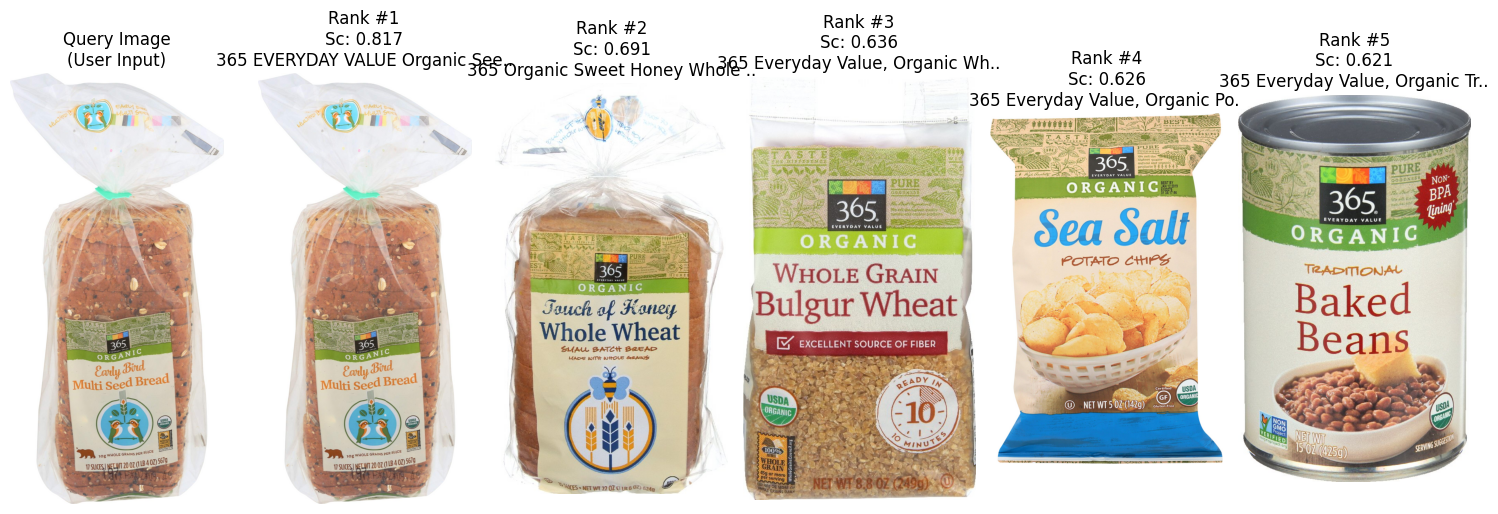

--- Eval Query: [{'language_tag': 'en_IN', 'value': 'Amazon Brand - Solimo Designer Wooden Bridge 3D Printed Hard Back Case Mobile Cover for Oppo Reno Ace/Realme X2 Pro'}] ---
Processing query: ../data/abo/images/original/02/02c81b6d.jpg
Generated Description: 'a wooden bridge in the woods with a blue sky phone case'

       TOP RESULTS


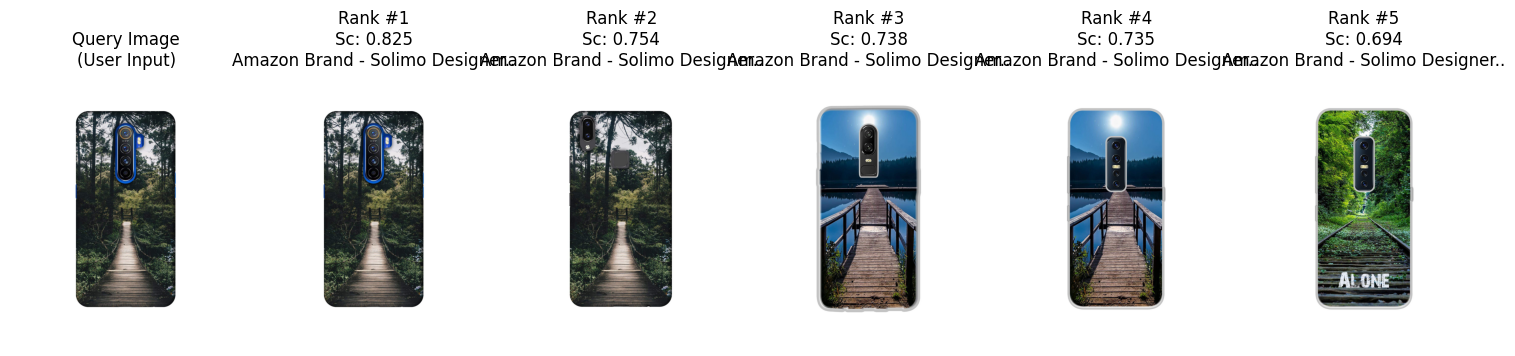

In [12]:
# Pick 3 random samples from different parts of the dataset to evaluate variety
# We'll try to pick samples that have different 'item_name' to ensure variety.

unique_products = df_merged.drop_duplicates(subset=['item_name'])
if len(unique_products) >= 3:
    test_samples = unique_products.sample(3)
else:
    test_samples = df_merged.sample(min(3, len(df_merged)))

print(f"Running Qualitative Evaluation on {len(test_samples)} samples...\n")

for idx, row in test_samples.iterrows():
    query_path = row['full_path']
    print(f"--- Eval Query: {row.get('item_name', 'Unknown')} ---")
    search_products(str(query_path), top_k=5)

### Quantitative Evaluation (Approximation)

To calculate **Precision@K** and **Recall@K**, we need "Ground Truth" (i.e., we need to know which images *should* be returned).

Since this is a catalog with unique products, we can define relevance in two ways:
1.  **Exact Product Match:** (If we had multiple images per product).
2.  **Category-Level Match:** (Did we return a *Shoe* when searching for a *Shoe*?).

Let's try **Category-Level Evaluation** using the `item_keywords` or `node` information if available in the listings. Or, we can simply rely on `item_id` if we happen to have multiple images of the same item (unlikely with just `main_image_id`).

Let's check if we have valid labels to evaluate against.

In [13]:
# Check relevant columns for ground truth
# 'product_type' or 'node' (category) would be good if available.
common_cols = [c for c in ['product_type', 'node', 'item_name', 'brand'] if c in df_merged.columns]
print(f"Potential columns for Ground Truth: {common_cols}")

if 'product_type' in df_merged.columns:
    label_col = 'product_type'
    print(f"Using '{label_col}' as class label.")
    
    # Display distribution
    print(df_merged[label_col].value_counts().head(10))
    
    # We can only evaluate categories that have at least 2 items (1 query, 1 match)
    valid_categories = df_merged[label_col].value_counts()
    valid_categories = valid_categories[valid_categories >= 2].index
    
    df_eval = df_merged[df_merged[label_col].isin(valid_categories)].copy()
    print(f"\nEval Set Size (Categories with >=2 items): {len(df_eval)}")
else:
    print("No obvious category column found. Cannot compute Category-Level P@K/R@K easily.")
    df_eval = pd.DataFrame() # Empty

Potential columns for Ground Truth: ['product_type', 'node', 'item_name', 'brand']
Using 'product_type' as class label.
product_type
[{'value': 'CELLULAR_PHONE_CASE'}]         532
[{'value': 'SHOES'}]                        98
[{'value': 'GROCERY'}]                      57
[{'value': 'HOME'}]                         47
[{'value': 'HOME_BED_AND_BATH'}]            19
[{'value': 'HOME_FURNITURE_AND_DECOR'}]     18
[{'value': 'FINERING'}]                     17
[{'value': 'ACCESSORY'}]                    13
[{'value': 'TABLE'}]                        12
[{'value': 'BOOT'}]                         11
Name: count, dtype: int64

Eval Set Size (Categories with >=2 items): 1108


In [ ]:
def calculate_metrics_at_k(embeddings, labels, k_values=[1, 5, 10]):
    """
    Simulated Image-to-Image Retrieval Evaluation.
    Query: One Image (embedding)
    Ground Truth: Other images with the SAME label (product_type)
    """
    if len(embeddings) < 2: return {}
    
    # Cosine Similarity Matrix (NxN)
    sim_matrix = embeddings @ embeddings.T
    
    # Mask self-matches (diagonal) so query doesn't match itself
    np.fill_diagonal(sim_matrix, -np.inf)
    
    n_samples = len(labels)
    # unique_labels = np.unique(labels) # Not strictly needed for calculation
    
    metrics = {f"P@{k}": [] for k in k_values}
    metrics.update({f"R@{k}": [] for k in k_values})
    
    # For every image in our eval set
    for i in tqdm(range(n_samples), desc="Evaluating P@K/R@K"):
        query_label = labels[i]
        
        # Get sorted indices of matches
        sorted_indices = np.argsort(sim_matrix[i])[::-1]
        
        # Evaluate for each K
        for k in k_values:
            top_k_indices = sorted_indices[:k]
            retrieved_labels = labels[top_k_indices]
            
            # Count matches
            n_relevant_retrieved = (retrieved_labels == query_label).sum()
            n_total_relevant = (labels == query_label).sum() - 1 # exclude self
            
            if n_total_relevant > 0:
                p_k = n_relevant_retrieved / k
                r_k = n_relevant_retrieved / n_total_relevant
                metrics[f"P@{k}"].append(p_k)
                metrics[f"R@{k}"].append(r_k)

    # Average
    avg_metrics = {k: np.mean(v) for k, v in metrics.items() if v}
    return avg_metrics

# -- Execute --
if not df_eval.empty:
    print("\nPreparing evaluation subset...")
    # Re-extract paths
    eval_paths = df_eval['full_path'].tolist()
    
    # CLEAN LABELS: Ensure they are strings, not dictionaries
    raw_labels = df_eval[label_col].values
    clean_labels = []
    for l in raw_labels:
        if isinstance(l, list) and len(l) > 0 and isinstance(l[0], dict):
             clean_labels.append(l[0].get('value', str(l)))
        elif isinstance(l, dict):
            clean_labels.append(l.get('value', str(l)))
        else:
            clean_labels.append(str(l))
            
    eval_labels = np.array(clean_labels)
    print(f"Sample clean labels: {eval_labels[:3]}")
    
    # We already computed embeddings for ALL images in 'image_embeddings'
    # We just need to index them correctly.
    # Map 'full_path' back to original index in df_merged
    path_to_idx = {p: i for i, p in enumerate(df_merged['full_path'])}
    eval_indices = [path_to_idx[p] for p in eval_paths]
    
    eval_embeddings = image_embeddings[eval_indices]
    
    print(f"Eval Set Shape: {eval_embeddings.shape}")
    
    # Calculate
    k_vals = [1, 5, 10]
    results = calculate_metrics_at_k(eval_embeddings, eval_labels, k_vals)
    
    print("\n--- Category-Level Retrieval Metrics ---")
    for k in k_vals:
        print(f"Precision@{k}: {results.get(f'P@{k}', 0):.4f} | Recall@{k}: {results.get(f'R@{k}', 0):.4f}")
else:
    print("Skipping evaluation: Not enough data per category.")


Preparing evaluation subset...
Eval Set Shape: (1108, 512)


TypeError: '<' not supported between instances of 'dict' and 'dict'